In [2]:
import numpy as np

import scipy.fftpack as fft
import scipy.ndimage as ndimage
import skimage.measure as measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from zero_form import ZeroForm
from one_form import OneForm
from poisson_solver import poisson_solve

In [3]:
X = np.load('./data/X.npy')
X.max(), X.min()

(np.float64(1.0013073113456232), np.float64(-1.0044286670585627))

In [4]:
def generate_grid_mesh(N = 32):
    L = 1.0
    h = L / N
    # Create the array of vertices, xyz indexing.
    V_ind = np.asarray([[[[i,j,k] for k in range(N)] for j in range(N)] for i in range(N)])
    V = V_ind * h
    return (V_ind, V)
N = X.shape[0]
V_ind, V = generate_grid_mesh(N = N)

In [5]:
def compute_codivergence(X_vectorfield):
    """
    Computes the codivergence (δX = ⋆ d ⋆ X) of a vector field X.

    Parameters:
        X_vectorfield: NumPy array of shape (Nx, Ny, Nz, 3), representing a discrete 1-form field.

    Returns:
        codiv_X: NumPy array of shape (Nx, Ny, Nz), representing the scalar field δX.
    """

    Nx, Ny, Nz, _ = X_vectorfield.shape

    # Step 1: Compute Hodge star (convert X to 2-form)
    X_dual = np.zeros_like(X_vectorfield)
    X_dual[..., 0] = X_vectorfield[..., 1]  # ⋆(dx) = dy∧dz
    X_dual[..., 1] = -X_vectorfield[..., 0] # ⋆(dy) = -dx∧dz
    X_dual[..., 2] = X_vectorfield[..., 2]  # ⋆(dz) = dx∧dy

    # Step 2: Compute exterior derivative d(⋆X) using finite differences
    dX_dual = np.zeros((Nx, Ny, Nz, 3))
    
    # Forward difference approximation for d(⋆X)
    dX_dual[..., 0] = np.roll(X_dual[..., 0], -1, axis=0) - X_dual[..., 0]  # ∂x
    dX_dual[..., 1] = np.roll(X_dual[..., 1], -1, axis=1) - X_dual[..., 1]  # ∂y
    dX_dual[..., 2] = np.roll(X_dual[..., 2], -1, axis=2) - X_dual[..., 2]  # ∂z

    # Step 3: Compute final Hodge star to obtain codivergence
    codiv_X = dX_dual[..., 0] + dX_dual[..., 1] + dX_dual[..., 2]  # Sum over all directions

    return codiv_X


In [6]:
def extract_surface(u, eta_norm, level=0.5):
    """
    Extracts a surface using Marching Cubes and computes per-vertex opacity based on eta_norm.
    
    Parameters:
        u (ndarray): Level set function.
        eta_norm (ndarray): Norm of eta, used for opacity scaling.
        level (float): Isosurface level.
    
    Returns:
        verts (ndarray): Vertices of the extracted surface.
        faces (ndarray): Triangles connecting the vertices.
        opacities (ndarray): Opacity values per vertex.
    """
    verts, faces, _, values = measure.marching_cubes(u, level=level)
    print(values)
    # Sample the opacity values from eta_norm at vertex locations
    opacities = ndimage.map_coordinates(eta_norm, verts.T, order=1)
    
    return verts, faces, opacities

In [7]:
def plot_surface_with_opacity(verts, faces, opacities):
    """
    Plots the 3D surface with transparency based on the norm of eta.
    
    Parameters:
        verts (ndarray): Surface vertices.
        faces (ndarray): Triangles defining the surface.
        opacities (ndarray): Opacity values per vertex.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Create a mesh with per-vertex opacity
    mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='k')

    # Set face colors based on opacity (gray scale)
    face_opacities = opacities[faces].mean(axis=1) * 0.8  # Average over each triangle
    face_colors = plt.cm.Greys(face_opacities)  # Map to grayscale colormap
    mesh.set_color(face_colors)

    mesh.set_alpha(0.2)

    ax.add_collection3d(mesh)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim(0, verts[:, 0].max())
    ax.set_ylim(0, verts[:, 1].max())
    ax.set_zlim(0, verts[:, 2].max())
    plt.show()



In [8]:
X_form = OneForm(V_ind, vector_field=X)
X_form_div = X_form.divergence()
X_form_div.shape

(64, 64, 64)

In [9]:
X_codiv = compute_codivergence(X)

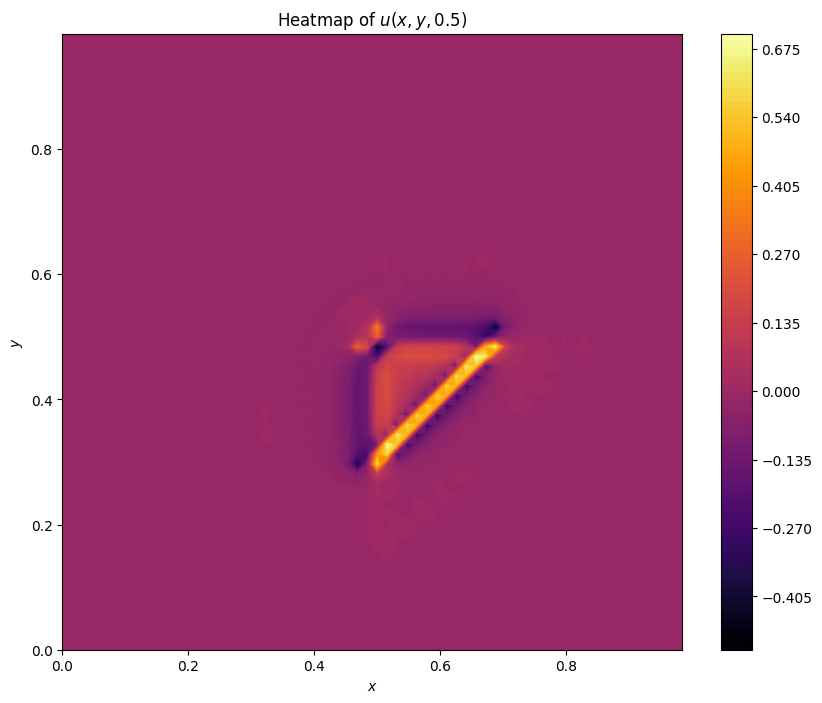

In [10]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], X_codiv[..., N // 2], levels=80, cmap='inferno')
plt.colorbar()
plt.title('Heatmap of $u(x, y, 0.5)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [11]:
np.linalg.norm(X, axis = -1).min()

np.float64(0.0)

In [12]:
def sharpen_level_set(u, strength=0.2):
    """Applies Laplacian sharpening to the level-set function u."""
    laplacian_u = (
        np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
        np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) +
        np.roll(u, 1, axis=2) + np.roll(u, -1, axis=2) - 6 * u
    )
    return u + strength * laplacian_u


In [13]:
u = poisson_solve(ZeroForm(V_ind, scalar_field=X_codiv)).real

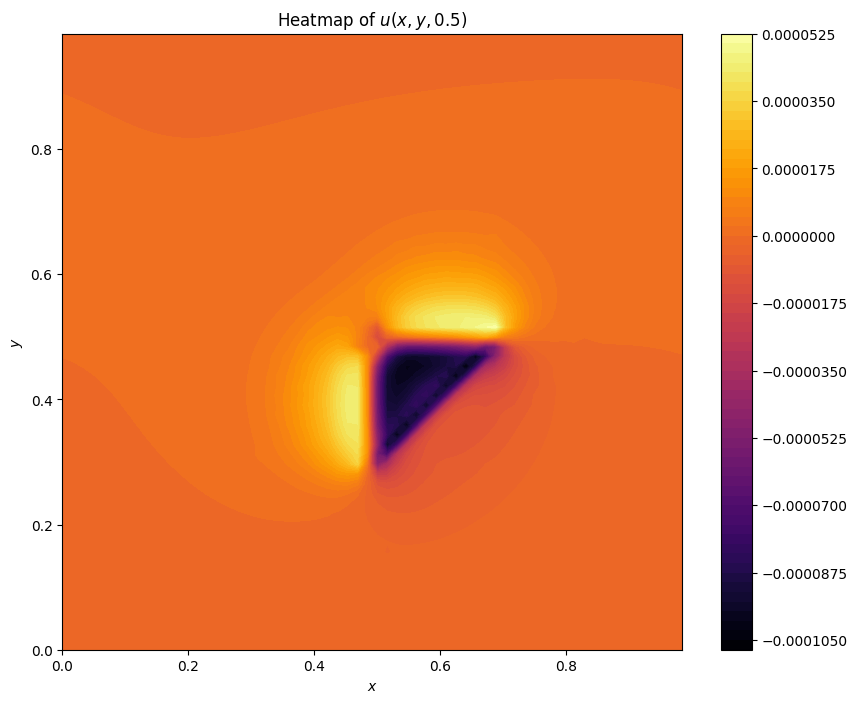

In [14]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], u[:, :, N // 2], levels=64, cmap='inferno')
plt.colorbar()
plt.title('Heatmap of $u(x, y, 0.5)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [15]:
def compute_eta_norm(eta):
    """
    Computes the norm of the 1-form eta, which is stored as a vector field.
    
    Parameters:
        eta (ndarray): 3D vector field representing eta.
    
    Returns:
        eta_norm (ndarray): Scalar field representing the magnitude of eta.
    """
    eta_norm = np.linalg.norm(eta, axis=-1)
    eta_norm /= eta_norm.max()  # Normalize to [0,1]
    return eta_norm

In [16]:
(u - u.min()) / (u.max() - u.min())

array([[[0.69428725, 0.69428542, 0.69428173, ..., 0.69428153,
         0.6942853 , 0.69428721],
        [0.69429346, 0.69429217, 0.69428892, ..., 0.6942855 ,
         0.69429011, 0.69429277],
        [0.69430116, 0.69430041, 0.69429759, ..., 0.69429097,
         0.69429642, 0.69429983],
        ...,
        [0.69427748, 0.69427398, 0.69426893, ..., 0.69427852,
         0.69427975, 0.69427941],
        [0.69427928, 0.69427634, 0.69427175, ..., 0.69427807,
         0.69428014, 0.69428055],
        [0.69428253, 0.69428015, 0.69427602, ..., 0.69427906,
         0.69428198, 0.69428314]],

       [[0.69426724, 0.69426436, 0.69425964, ..., 0.69426482,
         0.69426747, 0.69426828],
        [0.69427218, 0.69426964, 0.69426516, ..., 0.6942681 ,
         0.6942714 , 0.69427277],
        [0.69427846, 0.69427625, 0.694272  , ..., 0.69427275,
         0.6942767 , 0.69427861],
        ...,
        [0.6942604 , 0.6942564 , 0.69425088, ..., 0.69426308,
         0.69426374, 0.69426285],
        [0.6

[3.4066642e-07 4.5212454e-07 4.5212454e-07 ... 3.1536433e-07 2.7497208e-07
 2.7168198e-07]
[0. 0. 0. ... 0. 0. 0.]


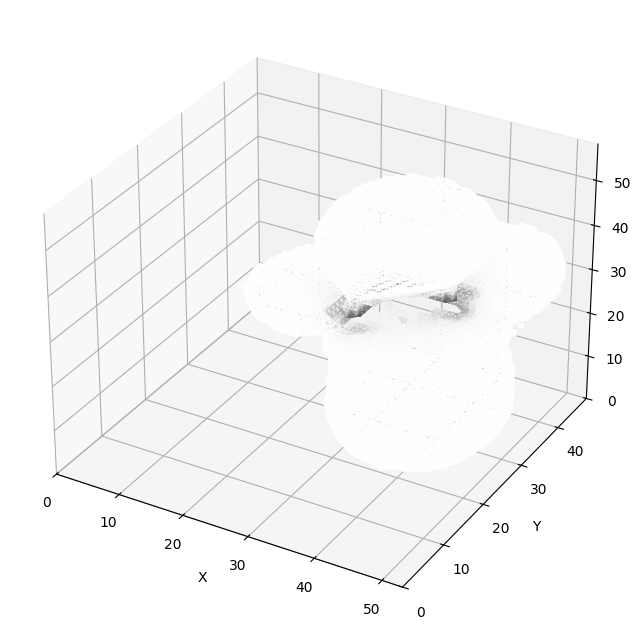

In [17]:
# Extract surface
eta_norm = compute_eta_norm(X)
vertices, faces, opacities = extract_surface(u, eta_norm, level = 0.000001)
vertices = vertices.astype(int)

print(opacities)
# Plot the minimal surface
plot_surface_with_opacity(vertices, faces, opacities)

# Remove boundary points

The mesh above represents the shape we want to obtain.  

However, it is evident that the mesh contains something else. The something else is mainly an artifact generated by the 

In [18]:
X_norm = np.linalg.norm(X, axis = -1)

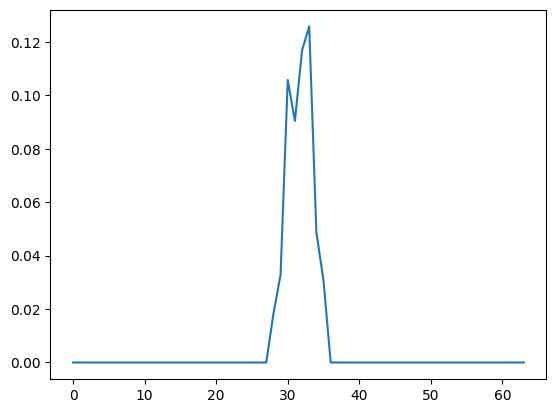

In [19]:
plt.plot(X_norm[N // 2, N // 2, :])

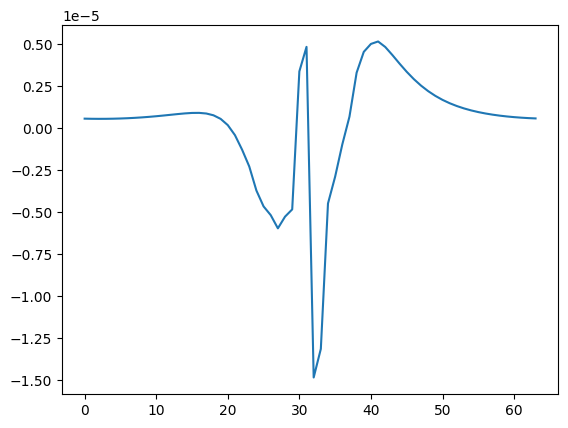

In [20]:
plt.plot(u[N // 2, N // 2, :])

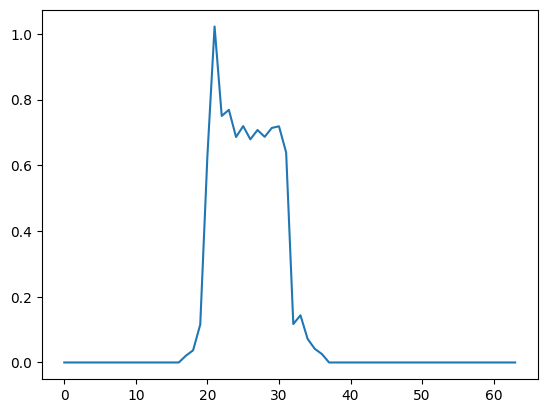

In [21]:
plt.plot(X_norm[N // 2, :, N // 2])

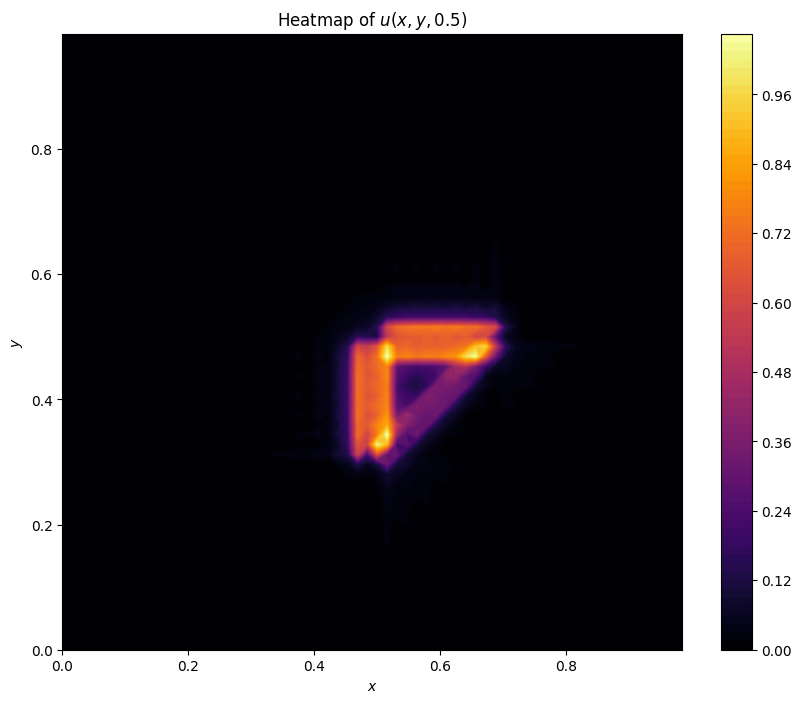

In [22]:

fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, N // 2, 0], V[:, :, N // 2, 1], X_norm[:, :, N // 2], levels=80, cmap='inferno')
plt.colorbar()
plt.title('Heatmap of $u(x, y, 0.5)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

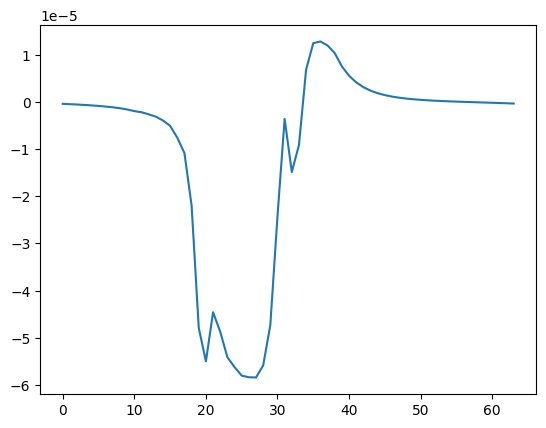

In [23]:
plt.plot(u[N // 2, :, N // 2])

In [24]:
# Find positions for which X norm is large
threshold = 0.1 * X_norm.max()

In [25]:
cleaned_vertices = []
cleaned_opacities = []
cleaned_vertex_indices = []
for i, v in enumerate(vertices):
    x, y, z = v
    if X_norm[x, y, z] <= threshold:
        cleaned_vertices.append(v)
        cleaned_opacities.append(opacities[i])
        cleaned_vertex_indices.append(i)
cleaned_vertices = np.asarray(cleaned_vertices)
cleaned_opacities = np.asarray(cleaned_opacities)
cleaned_vertex_indices = np.asarray(cleaned_vertex_indices)


# Faces
cleaned_faces = []
for f in faces:
    if f[0] in cleaned_vertex_indices and f[1] in cleaned_vertex_indices and f[2] in cleaned_vertex_indices:
        cleaned_faces.append(f)
cleaned_faces = np.asarray(cleaned_faces)
cleaned_faces

array([[   2,    1,    0],
       [   0,    3,    2],
       [   1,    4,    0],
       ...,
       [8093, 8148, 8095],
       [8095, 8148, 8149],
       [8095, 8149, 8087]], shape=(14782, 3), dtype=int32)

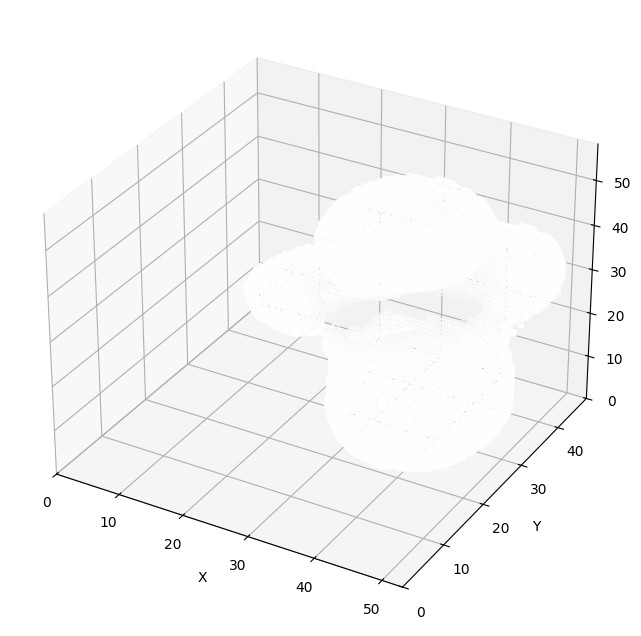

In [26]:
plot_surface_with_opacity(vertices, cleaned_faces, opacities)